# Jリーグの動員数予測

In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode(connected=True)
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pandas.tseries.offsets import *
%matplotlib inline

In [3]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### データ読み込み  
train  
holidays_in_japan  
match_reports  
sample_submit  
stadium_capacity_mapping  
test  

In [4]:
train = pd.read_csv("train.csv" )
holidays_in_japan = pd.read_csv("holidays_in_japan.csv" )
match_reports= pd.read_csv("match_reports.csv" )
stadium_capacity_mapping= pd.read_csv("stadium_capacity_mapping.csv" )

sample_submit= pd.read_csv("sample_submit.csv" )
test = pd.read_csv("test.csv") 

In [6]:
#compose_processing= pd.read_csv("compose_processing.csv" )
compose_processing= pd.read_csv("compose_processing6.csv" , encoding="shift_jis")

C:\Users\Mustang8\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning:

Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.



In [7]:
compose_processing.columns

Index(['attendance', 'away_team', 'broadcasters', 'home_team', 'humidity',
       'id', 'match_date', 'round', 'section', 'temperature',
       ...
       'venuer138', 'venuer139', 'venuer140', 'venuer141', 'venuer142',
       'venuer143', 'venuer144', 'venuer145', 'venuer146', 'venuer147'],
      dtype='object', length=244)

In [8]:
compose_processing

,attendance,away_team,broadcasters,home_team,humidity,id,match_date,round,section,temperature,...,venuer138,venuer139,venuer140,venuer141,venuer142,venuer143,venuer144,venuer145,venuer146,venuer147
0,59626.0,0,0,0,60.653314,49,1993-05-15,0,0,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14126.0,1,0,1,60.653314,50,1993-05-16,1,0,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11875.0,2,0,2,60.653314,51,1993-05-16,1,0,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10898.0,3,0,3,60.653314,52,1993-05-16,1,0,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19580.0,4,0,4,60.653314,53,1993-05-16,1,0,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,9183.0,5,0,5,60.653314,58,1993-05-19,0,1,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,9259.0,3,0,6,60.653314,56,1993-05-19,0,1,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,10332.0,6,0,7,60.653314,57,1993-05-19,0,1,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9403.0,7,0,3,60.653314,54,1993-05-19,0,1,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,46959.0,8,0,8,60.653314,55,1993-05-19,0,1,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 特徴量エンジニアリング終了（数値化）

# 2.モデリング

compose:2006-3/4～ 2016-3/20  
train  :2006 3/4～ 2016 11/3  
test   :2017 2/25～2018 12/1  
2006-2/1~2015-12/30をtrain ,2016-3/1~2016-11/301をvalidにする  
(12~1月は試合がないので,データは存在しない)

In [9]:
(pd.to_datetime(compose_processing["match_date"] )>= pd.to_datetime("2006-2-1")) & (pd.to_datetime(compose_processing["match_date"]) < pd.to_datetime("2010-11-30"))

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
8980    False
8981    False
8982    False
8983    False
8984    False
8985    False
8986    False
8987    False
8988    False
8989    False
8990    False
8991    False
8992    False
8993    False
8994    False
8995    False
8996    False
8997    False
8998    False
8999    False
9000    False
9001    False
9002    False
9003    False
9004    False
9005    False
9006    False
9007    False
9008    False
9009    False
Name: match_date, Length: 9010, dtype: bool

名前が被るので一文字目は大文字に設定  
trainデータをTrain Validに分割　
testはTestデータ

Train =  compose_processing.loc[(pd.to_datetime(compose_processing["match_date"]) < pd.to_datetime("2010-11-30")),:]

Valid = compose_processing.loc[(pd.to_datetime(compose_processing["match_date"]) >= pd.to_datetime("2010-11-30")) & 
                               (pd.to_datetime(compose_processing["match_date"]) < pd.to_datetime("2017-2-24")),:]
Valid = Valid.reset_index(drop=True).copy()

Test =  compose_processing.loc[(pd.to_datetime(compose_processing["match_date"]) >= pd.to_datetime("2017-2-25")) & 
                               (pd.to_datetime(compose_processing["match_date"]) < pd.to_datetime("2018-12-1")),:]

In [10]:
compose_processing.shape

(9010, 244)

In [11]:
compose_processing

,attendance,away_team,broadcasters,home_team,humidity,id,match_date,round,section,temperature,...,venuer138,venuer139,venuer140,venuer141,venuer142,venuer143,venuer144,venuer145,venuer146,venuer147
0,59626.0,0,0,0,60.653314,49,1993-05-15,0,0,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14126.0,1,0,1,60.653314,50,1993-05-16,1,0,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11875.0,2,0,2,60.653314,51,1993-05-16,1,0,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10898.0,3,0,3,60.653314,52,1993-05-16,1,0,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19580.0,4,0,4,60.653314,53,1993-05-16,1,0,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,9183.0,5,0,5,60.653314,58,1993-05-19,0,1,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,9259.0,3,0,6,60.653314,56,1993-05-19,0,1,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,10332.0,6,0,7,60.653314,57,1993-05-19,0,1,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9403.0,7,0,3,60.653314,54,1993-05-19,0,1,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,46959.0,8,0,8,60.653314,55,1993-05-19,0,1,20.943044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
train =  compose_processing.loc[(pd.to_datetime(compose_processing["match_date"]) < pd.to_datetime("2017-2-24")),:]


test =  compose_processing.loc[(pd.to_datetime(compose_processing["match_date"]) >= pd.to_datetime("2017-2-25")) ,:]

In [13]:
print(train.shape)
print(test.shape)

(8533, 244)
(477, 244)


In [14]:
#重複行削除
train2= train.drop_duplicates(inplace = False,subset="id")
print(train2.shape)

(8488, 244)


In [15]:
#重複行削除
test2= test.drop_duplicates(inplace = False,subset="id")
print(test2.shape)

(477, 244)


In [16]:
test2.reset_index

<bound method DataFrame.reset_index of       attendance  away_team  broadcasters  home_team   humidity     id  \
8533         NaN          4          1469         18  45.000000  19075   
8534         NaN         17          1470         22  36.000000  19076   
8535         NaN         37          1471          3  63.000000  19077   
8536         NaN         16          1472          5  40.000000  19078   
8537         NaN         24          1473          2  45.000000  19079   
8538         NaN         12          1474         28  34.000000  19080   
8539         NaN         10          1475         39  41.000000  19081   
8540         NaN         38          1476         25  26.000000  19082   
8541         NaN         27          1475         36  35.000000  19083   
8542         NaN         36          1471          6  39.000000  19084   
8543         NaN          9          1477         27  36.000000  19085   
8544         NaN          1          1478          2  29.000000  19086   

In [17]:
test2.head()

,attendance,away_team,broadcasters,home_team,humidity,id,match_date,round,section,temperature,...,venuer138,venuer139,venuer140,venuer141,venuer142,venuer143,venuer144,venuer145,venuer146,venuer147
8533,NaN,4,1469,18,45.0,19075,2017-02-25,4,44,10.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8534,NaN,17,1470,22,36.0,19076,2017-02-25,4,44,10.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8535,NaN,37,1471,3,63.0,19077,2017-02-25,4,44,10.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8536,NaN,16,1472,5,40.0,19078,2017-02-25,4,44,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8537,NaN,24,1473,2,45.0,19079,2017-02-25,4,44,11.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
test

,attendance,away_team,broadcasters,home_team,humidity,id,match_date,round,section,temperature,venue,weather,capacity,description,match_date_year,match_date_month,match_date_day,kick_off_time_hour,kick_off_time_minute,match_date_weekday,home_team_win,home_team_score,away_team_score,weather0,weather1,weather2,weather3,weather4,weather5,weather6,weather7,weather8,weather9,weather10,weather11,weather12,weather13,weather14,weather15,weather16,weather17,weather18,weather19,weather20,weather21,weather22,weather23,weather24,weather25,weather26,...,venuer98,venuer99,venuer100,venuer101,venuer102,venuer103,venuer104,venuer105,venuer106,venuer107,venuer108,venuer109,venuer110,venuer111,venuer112,venuer113,venuer114,venuer115,venuer116,venuer117,venuer118,venuer119,venuer120,venuer121,venuer122,venuer123,venuer124,venuer125,venuer126,venuer127,venuer128,venuer129,venuer130,venuer131,venuer132,venuer133,venuer134,venuer135,venuer136,venuer137,venuer138,venuer139,venuer140,venuer141,venuer142,venuer143,venuer144,venuer145,venuer146,venuer147
8533,NaN,4,1469,18,45.000000,19075,2017-02-25,4,44,10.200000,81,0,72327.0,0,2017,2,25,12,35,5,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8534,NaN,17,1470,22,36.000000,19076,2017-02-25,4,44,10.600000,118,1,19694.0,0,2017,2,25,14,4,5,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8535,NaN,37,1471,3,63.000000,19077,2017-02-25,4,44,10.100000,3,0,40728.0,0,2017,2,25,14,4,5,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8536,NaN,16,1472,5,40.000000,19078,2017-02-25,4,44,15.000000,137,0,20248.0,0,2017,2,25,14,4,5,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8537,NaN,24,1473,2,45.000000,19079,2017-02-25,4,44,11.200000,135,0,NaN,0,2017,2,25,14,4,5,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8538,NaN,12,1474,28,34.000000,19080,2017-02-25,4,44,14.800000,134,0,24130.0,0,2017,2,25,14,5,5,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8539,NaN,10,1475,39,41.000000,19081,2017-02-25,4,44,9.700000,139,0,47000.0,0,2017,2,25,15,3,5,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8540,NaN,38,1476,25,26.000000,1908

In [23]:
pd.set_option('display.max_columns', 100)

In [26]:
print(train.columns.all)

<bound method Index._add_logical_methods.<locals>._make_logical_function.<locals>.logical_func of Index(['attendance', 'away_team', 'broadcasters', 'home_team', 'humidity',
       'id', 'match_date', 'round', 'section', 'temperature',
       ...
       'venuer138', 'venuer139', 'venuer140', 'venuer141', 'venuer142',
       'venuer143', 'venuer144', 'venuer145', 'venuer146', 'venuer147'],
      dtype='object', length=244)>


In [35]:
for i in range(148):
    print("'venuer%d' ,"%i)

'venuer0' ,
'venuer1' ,
'venuer2' ,
'venuer3' ,
'venuer4' ,
'venuer5' ,
'venuer6' ,
'venuer7' ,
'venuer8' ,
'venuer9' ,
'venuer10' ,
'venuer11' ,
'venuer12' ,
'venuer13' ,
'venuer14' ,
'venuer15' ,
'venuer16' ,
'venuer17' ,
'venuer18' ,
'venuer19' ,
'venuer20' ,
'venuer21' ,
'venuer22' ,
'venuer23' ,
'venuer24' ,
'venuer25' ,
'venuer26' ,
'venuer27' ,
'venuer28' ,
'venuer29' ,
'venuer30' ,
'venuer31' ,
'venuer32' ,
'venuer33' ,
'venuer34' ,
'venuer35' ,
'venuer36' ,
'venuer37' ,
'venuer38' ,
'venuer39' ,
'venuer40' ,
'venuer41' ,
'venuer42' ,
'venuer43' ,
'venuer44' ,
'venuer45' ,
'venuer46' ,
'venuer47' ,
'venuer48' ,
'venuer49' ,
'venuer50' ,
'venuer51' ,
'venuer52' ,
'venuer53' ,
'venuer54' ,
'venuer55' ,
'venuer56' ,
'venuer57' ,
'venuer58' ,
'venuer59' ,
'venuer60' ,
'venuer61' ,
'venuer62' ,
'venuer63' ,
'venuer64' ,
'venuer65' ,
'venuer66' ,
'venuer67' ,
'venuer68' ,
'venuer69' ,
'venuer70' ,
'venuer71' ,
'venuer72' ,
'venuer73' ,
'venuer74' ,
'venuer75' ,
'venuer76' ,
'venuer77

In [36]:
#ここでモデリングに使う特徴量を選択する
feature_name=['away_team',  'home_team',
       'humidity', 'round',  'broadcasters','section', 'temperature',
        'capacity', 'description', 'match_date_year',
       'match_date_month', 'match_date_day', 'kick_off_time_hour',
       'kick_off_time_minute', 'match_date_weekday', 'home_team_win',
       'home_team_score', 'away_team_score'
        ,'weather0', 'weather1',
       'weather2', 'weather3', 'weather4', 'weather5', 'weather6', 'weather7',
       'weather8', 'weather9', 'weather10', 'weather11', 'weather12',
       'weather13', 'weather14', 'weather15', 'weather16', 'weather17',
       'weather18', 'weather19', 'weather20', 'weather21', 'weather22',
       'weather23', 'weather24', 'weather25', 'weather26', 'weather27',
       'weather28', 'weather29', 'weather30', 'weather31', 'weather32',
       'weather33', 'weather34', 'weather35', 'weather36', 'weather37',
       'weather38', 'weather39', 'weather40', 'weather41', 'weather42',
       'weather43', 'weather44', 'weather45', 'weather46', 'weather47',
       'weather48', 'weather49', 'weather50', 'weather51', 'weather52',
       'weather53', 'weather54', 'weather55', 'weather56', 'weather57',
       'weather58', 'weather59', 'weather60', 'weather61', 'weather62',
       'weather63', 'weather64', 'weather65', 'weather66', 'weather67',
       'weather68', 'weather69', 'weather70', 'weather71', 'weather72',
      'venuer0' ,
'venuer1' ,'venuer2' ,'venuer3' ,'venuer4' ,'venuer5' ,'venuer6' ,'venuer7' ,'venuer8' ,'venuer9' ,'venuer10' ,
'venuer11' ,'venuer12' ,'venuer13' ,'venuer14' ,
'venuer15' ,
'venuer16' ,
'venuer17' ,
'venuer18' ,
'venuer19' ,
'venuer20' ,
'venuer21' ,
'venuer22' ,
'venuer23' ,
'venuer24' ,
'venuer25' ,
'venuer26' ,
'venuer27' ,
'venuer28' ,
'venuer29' ,
'venuer30' ,
'venuer31' ,
'venuer32' ,
'venuer33' ,
'venuer34' ,
'venuer35' ,
'venuer36' ,
'venuer37' ,
'venuer38' ,
'venuer39' ,
'venuer40' ,
'venuer41' ,
'venuer42' ,
'venuer43' ,
'venuer44' ,
'venuer45' ,
'venuer46' ,
'venuer47' ,
'venuer48' ,
'venuer49' ,
'venuer50' ,
'venuer51' ,
'venuer52' ,
'venuer53' ,
'venuer54' ,
'venuer55' ,
'venuer56' ,
'venuer57' ,
'venuer58' ,
'venuer59' ,
'venuer60' ,
'venuer61' ,
'venuer62' ,
'venuer63' ,
'venuer64' ,
'venuer65' ,
'venuer66' ,
'venuer67' ,
'venuer68' ,
'venuer69' ,
'venuer70' ,
'venuer71' ,
'venuer72' ,
'venuer73' ,
'venuer74' ,
'venuer75' ,
'venuer76' ,
'venuer77' ,
'venuer78' ,
'venuer79' ,
'venuer80' ,
'venuer81' ,
'venuer82' ,
'venuer83' ,
'venuer84' ,
'venuer85' ,
'venuer86' ,
'venuer87' ,
'venuer88' ,
'venuer89' ,
'venuer90' ,
'venuer91' ,
'venuer92' ,
'venuer93' ,
'venuer94' ,
'venuer95' ,
'venuer96' ,
'venuer97' ,
'venuer98' ,
'venuer99' ,
'venuer100' ,
'venuer101' ,
'venuer102' ,
'venuer103' ,
'venuer104' ,
'venuer105' ,
'venuer106' ,
'venuer107' ,
'venuer108' ,
'venuer109' ,
'venuer110' ,
'venuer111' ,
'venuer112' ,
'venuer113' ,
'venuer114' ,
'venuer115' ,
'venuer116' ,
'venuer117' ,
'venuer118' ,
'venuer119' ,
'venuer120' ,
'venuer121' ,
'venuer122' ,
'venuer123' ,
'venuer124' ,
'venuer125' ,
'venuer126' ,
'venuer127' ,
'venuer128' ,
'venuer129' ,
'venuer130' ,
'venuer131' ,
'venuer132' ,
'venuer133' ,
'venuer134' ,
'venuer135' ,
'venuer136' ,
'venuer137' ,
'venuer138' ,
'venuer139' ,
'venuer140' ,
'venuer141' ,
'venuer142' ,
'venuer143' ,
'venuer144' ,
'venuer145' ,
'venuer146' ,
'venuer147' ,]

In [37]:
feature = train[feature_name]
y=train["attendance"]
print(feature.shape)
feature.head()

(8533, 239)


,away_team,home_team,humidity,round,broadcasters,section,temperature,capacity,description,match_date_year,match_date_month,match_date_day,kick_off_time_hour,kick_off_time_minute,match_date_weekday,home_team_win,home_team_score,away_team_score,weather0,weather1,weather2,weather3,weather4,weather5,weather6,weather7,weather8,weather9,weather10,weather11,weather12,weather13,weather14,weather15,weather16,weather17,weather18,weather19,weather20,weather21,weather22,weather23,weather24,weather25,weather26,weather27,weather28,weather29,weather30,weather31,...,venuer98,venuer99,venuer100,venuer101,venuer102,venuer103,venuer104,venuer105,venuer106,venuer107,venuer108,venuer109,venuer110,venuer111,venuer112,venuer113,venuer114,venuer115,venuer116,venuer117,venuer118,venuer119,venuer120,venuer121,venuer122,venuer123,venuer124,venuer125,venuer126,venuer127,venuer128,venuer129,venuer130,venuer131,venuer132,venuer133,venuer134,venuer135,venuer136,venuer137,venuer138,venuer139,venuer140,venuer141,venuer142,venuer143,venuer144,venuer145,venuer146,venuer147
0,0,0,60.653314,0,0,0,20.943044,48000.0,0,1993,5,15,19,29,5,False,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,60.653314,1,0,0,20.943044,NaN,0,1993,5,16,13,5,6,True,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,60.653314,1,0,0,20.943044,NaN,0,1993,5,16,13,59,6,True,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,60.653314,1,0,0,20.943044,40728.0,0,1993,5,16,16,0,6,True,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,60.653314,1,0,0,20.943044,21000.0,0,1993,5,16,19,4,6,True,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#gridsearch 時間かかるのでパラメータ調整したいときのみ実行

xgb_pars = []

MCWlist = [10, 20, 30,40,50]
ETAlist =  [0.05,0.1,0.2,0.3]
CSlist = [0.3,0.5,0.7]
MDlist =  [6,7,8,9,10]
SSlist = [0.5,0.7,0.9]
LAMBDAlist = [0.5,0.6,0.7]

for MCW in MCWlist:

    for ETA in ETAlist:

        for CS in CSlist:

            for MD in MDlist:

                for SS in SSlist:

                    for LAMBDA in LAMBDAlist:

                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 

                                         'colsample_bytree': CS, 'max_depth': MD,

                                         'subsample': SS, 'lambda': LAMBDA, 

                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',

                                         'silent': 1, 'objective': 'reg:linear'})
patterns = len(MCWlist)*len(ETAlist)*len(CSlist)*len(MDlist)*len(SSlist)*len(LAMBDAlist)
print(patterns)

2700


In [39]:
(feature.values).shape

(8533, 239)

In [40]:
(y.values).shape

(8533,)

In [41]:
Xtr, Xv, ytr, yv = train_test_split(feature.values, y.values, test_size=0.2,random_state = False )
dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=feature_name)
dvalid = xgb.DMatrix(Xv, label=yv, feature_names = feature_name)
watchlist = [(dtrain,"train"),(dvalid,"valid")]

In [150]:
scores =[]
for i in range(len(xgb_pars)):
    res = xgb.cv(xgb_pars[i], dtrain, num_boost_round=1000,early_stopping_rounds=50,
                 nfold=5,metrics={'rmse'}, seed = 0,verbose_eval = None)
    scores.append(res.loc[:,"test-rmse-mean"].min())
    print(i/patterns)

    
print("____________________________________")
print("best score")
print(pd.Series(scores).min())
print("best param")
print(xgb_pars[pd.Series(scores).argmin()])

KeyboardInterrupt: 

In [42]:
#score 0.249(外部データなし) 1000回繰り返し
xgb_pars = {'min_child_weight': 10, 'eta': 0.05, 'colsample_bytree': 0.7, 'max_depth': 6, 'subsample': 0.9, 'lambda': 0.6, 'nthread': -1, 
            'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}

In [43]:
model = xgb.train(xgb_pars, dtrain, 5000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:17004.5	valid-rmse:16891.4
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:11087	valid-rmse:11075.5
[20]	train-rmse:7830.27	valid-rmse:7951.6
[30]	train-rmse:6026.24	valid-rmse:6288.43
[40]	train-rmse:5054.62	valid-rmse:5460.91
[50]	train-rmse:4536.72	valid-rmse:5049.23
[60]	train-rmse:4226.39	valid-rmse:4836.04
[70]	train-rmse:4027.11	valid-rmse:4701.27
[80]	train-rmse:3863.01	valid-rmse:4603.08
[90]	train-rmse:3751.07	valid-rmse:4534.05
[100]	train-rmse:3663.6	valid-rmse:4482.24
[110]	train-rmse:3583.15	valid-rmse:4435.87
[120]	train-rmse:3509.4	valid-rmse:4394.66
[130]	train-rmse:3460.93	valid-rmse:4366.06
[140]	train-rmse:3427.68	valid-rmse:4344.48
[150]	train-rmse:3370.78	valid-rmse:4317.65
[160]	train-rmse:3331.62	valid-rmse:4296.01
[170]	train-rmse:3289.45	valid-rmse:4268.91
[180]	train-rmse:3260.34	valid-rmse:4255.52
[190]	train-rmse:3221.07	valid-rmse

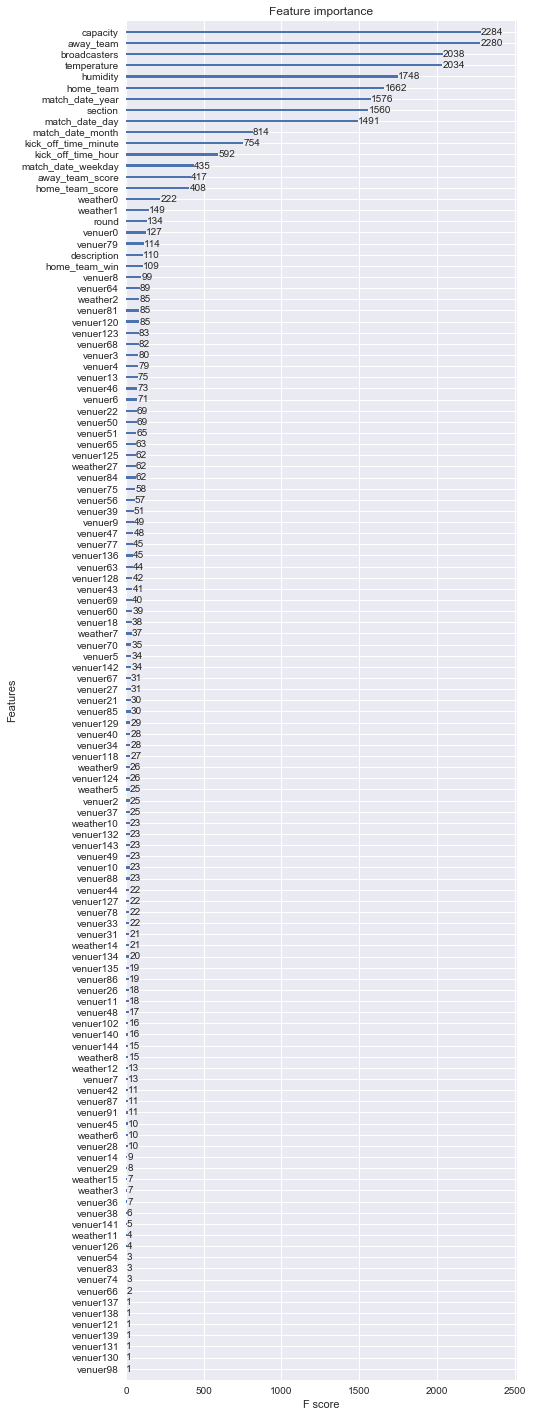

In [44]:
fig, ax = plt.subplots(1,1,figsize=(7,25))
xgb.plot_importance(model,ax=ax)

# 3.pridict

In [45]:
dfeature = xgb.DMatrix(feature.values, label=y.values, feature_names=feature_name)

train_predict = model.predict(dfeature)
print(train_predict.shape)
train_predict

(8533,)


array([58630.93 , 14316.51 , 11520.251, ..., 28543.338, 16971.85 ,
       14060.299], dtype=float32)

In [46]:
test_feature = test[feature_name]
test_y=test["attendance"]
print(test_feature.shape)
test_feature.head()

(477, 239)


,away_team,home_team,humidity,round,broadcasters,section,temperature,capacity,description,match_date_year,match_date_month,match_date_day,kick_off_time_hour,kick_off_time_minute,match_date_weekday,home_team_win,home_team_score,away_team_score,weather0,weather1,weather2,weather3,weather4,weather5,weather6,weather7,weather8,weather9,weather10,weather11,weather12,weather13,weather14,weather15,weather16,weather17,weather18,weather19,weather20,weather21,weather22,weather23,weather24,weather25,weather26,weather27,weather28,weather29,weather30,weather31,...,venuer98,venuer99,venuer100,venuer101,venuer102,venuer103,venuer104,venuer105,venuer106,venuer107,venuer108,venuer109,venuer110,venuer111,venuer112,venuer113,venuer114,venuer115,venuer116,venuer117,venuer118,venuer119,venuer120,venuer121,venuer122,venuer123,venuer124,venuer125,venuer126,venuer127,venuer128,venuer129,venuer130,venuer131,venuer132,venuer133,venuer134,venuer135,venuer136,venuer137,venuer138,venuer139,venuer140,venuer141,venuer142,venuer143,venuer144,venuer145,venuer146,venuer147
8533,4,18,45.0,4,1469,44,10.2,72327.0,0,2017,2,25,12,35,5,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8534,17,22,36.0,4,1470,44,10.6,19694.0,0,2017,2,25,14,4,5,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8535,37,3,63.0,4,1471,44,10.1,40728.0,0,2017,2,25,14,4,5,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8536,16,5,40.0,4,1472,44,15.0,20248.0,0,2017,2,25,14,4,5,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8537,24,2,45.0,4,1473,44,11.2,NaN,0,2017,2,25,14,4,5,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
dtest = xgb.DMatrix(test_feature.values, label=test_y.values, feature_names=feature_name)
test_predict = model.predict(dtest)
print(test_predict.shape)
test_predict

(477,)


array([47399.523 , 16420.912 , 22553.838 , 15342.244 , 18157.295 ,
       13553.553 , 27685.188 , 14152.805 , 25267.527 , 46024.383 ,
       14668.183 , 18360.732 , 25609.703 , 13521.491 , 17319.06  ,
       14699.861 , 15337.966 , 22103.2   , 13685.154 , 15104.902 ,
       31428.988 , 16934.002 , 11579.022 , 12248.127 , 19522.668 ,
       13019.706 , 23004.432 , 18241.69  , 23597.607 ,  9333.481 ,
       15650.8545,  9967.262 , 14041.314 , 15810.845 , 28602.662 ,
       30793.701 , 14315.221 , 26852.443 , 12944.481 , 20260.758 ,
       17446.14  , 19359.564 , 19438.32  ,  9045.313 , 10315.731 ,
       17502.53  , 30479.893 , 14900.514 , 15990.088 ,  9043.262 ,
        7303.409 ,  9215.537 , 14737.609 , 22964.582 , 14327.269 ,
       11027.376 , 13974.564 , 34695.953 , 33435.81  , 10883.426 ,
       13225.378 , 16242.198 , 16172.031 , 14813.407 , 17914.15  ,
       36230.582 , 11647.656 , 14671.257 , 18897.49  , 12375.711 ,
       22415.021 , 11475.177 , 15269.662 , 22608.664 , 16620.2

In [48]:
tr_diviation = train["attendance"]-train_predict
tr_mae = np.absolute(tr_diviation).mean()
te_diviation = test["attendance"]-test_predict
te_mae = np.absolute(te_diviation).mean()
print("trainデータの予想のMAE =",tr_mae)
print("testデータの予想のMAE =",te_mae)

trainデータの予想のMAE = 1577.5738259457094
testデータの予想のMAE = nan


In [49]:
len(test_predict)

477

In [50]:
len(test)

477

In [51]:
te_predict = pd.DataFrame(test_predict)
te_predict.columns = ["predict"]
test_use = test.reset_index()
te_predict.loc[:,"id"] = test_use["id"]
te_predict.columns = ["predict","id"]
print(te_predict.shape)
te_predict.tail()

(477, 2)


,predict,id
472,14348.908203,30013
473,29589.441406,30014
474,15648.563477,30015
475,18918.324219,30016
476,14854.708008,30017


# 4.提出 

In [52]:
te_predict= te_predict.ix[:,['id','predict']]

C:\Users\Mustang8\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [53]:
te_predict = te_predict.sort_values(by = "id")

In [54]:
te_predict.tail()

,id,predict
472,30013,14348.908203
473,30014,29589.441406
474,30015,15648.563477
475,30016,18918.324219
476,30017,14854.708008


In [55]:
te_predict.to_csv("submission.csv",header=None,index=None)